* [Functions](#Functions)
* [Naive test](#Naive-test)
* [Imputation](#Imputation)
* [Interpretation of timestamp](#Interpretation-of-timestamp)
* [handling bugs from `build_year` field:](#handling-bugs-from-build_year-field:)
* [treat wrong `build_year`s as NaN:](#treat-wrong-build_years-as-NaN:)
* [handling outlier data in `full_sq, life_sq, kitch_sq`:](#handling-outlier-data-in-full_sq,-life_sq,-kitch_sq:)
* [try to correct the bad relations between `kitch-sq`, `life_sq`, `full_sq`](#try-to-correct-the-bad-relations-between-kitch-sq,-life_sq,-full_sq)
* [treat the bad values of `kitch-sq`, `life_sq`, `full_sq` as NaN](#treat-the-bad-values-of-kitch-sq,-life_sq,-full_sq-as-NaN)
* [treat outliers in `num_room` as NaN](#treat-outliers-in-num_room-as-NaN)
* [Replacing `floor` with `max_floor` for wrong values](#Replacing-floor-with-max_floor-for-wrong-values)
* [treat wring values in `floor` as NaN](#treat-wring-values-in-floor-as-NaN)
* [remove outlier from `state`](#remove-outlier-from-state)
* [Adding age instead of build_year](#Adding-age-instead-of-build_year)
* [Some feature engineering](#Some-feature-engineering)
* [All bug removal from dataset and feature engineering](#All-bug-removal-from-dataset-and-feature-engineering)
* [Imputation + Feature Engineering](#Imputation-+-Feature-Engineering)
* [Feature importance](#Feature-importance)
* [Using `macro` dataset](#Using-macro-dataset)
* [Using feature importance on train_macro](#Using-feature-importance-on-train_macro)
* [Dimension Reduction](#Dimension-Reduction)





In [1]:
import pandas as pd
import numpy as np
import scipy as scp
from scipy import stats
import sklearn 
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('./data/Sber Bank/train.csv')
train_cols = train.drop(['id', 'price_doc'], axis=1).columns
macro = pd.read_csv('./data/Sber Bank/macro.csv')
macro_cols = macro.columns
train = pd.merge(train, macro, on='timestamp')

In [3]:
train.timestamp = pd.to_datetime(train.timestamp)

for c in train.columns:
    if train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[c].values)) 
        train[c] = lbl.transform(list(train[c].values))

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop(['id', 'price_doc'], axis=1), 
                                                    train['price_doc'], 
                                                    test_size=0.3, 
                                                    random_state=42)

print 'Length of X_train data: {}'.format(X_train.shape) 
print 'Length of y_train data: {}'.format(y_train.shape) 
print 'Length of X_test data:  {}'.format(X_test.shape)
print 'Length of y_test data:  {}'.format(y_test.shape) 

Length of X_train data: (21329, 389)
Length of y_train data: (21329L,)
Length of X_test data:  (9142, 389)
Length of y_test data:  (9142L,)


## Functions

In [5]:
# Root Mean Squared Log error
def RMSLE(y, y_):
    return np.sqrt(np.mean(np.log((y+1)/(y_+1))**2))

In [6]:
def model_eval(estimator, X_train, y_train, X_test, y_test):
    #train_cv_score = cross_val_score(xgr, X_train, y_train, cv=5)
    y_train_pred = cross_val_predict(estimator, X_train, y_train, cv=5)
    train_r2_score = r2_score(y_train, y_train_pred)
    train_mse = np.sqrt(np.mean((y_train-y_train_pred)**2))
    train_rmsle = RMSLE(y_train, y_train_pred)
    
    model = estimator.fit(X_train, y_train)
    y_test_pred = estimator.predict(X_test)
    test_r2_score = r2_score(y_test, y_test_pred)
    test_mse = np.sqrt(np.mean((y_test-y_test_pred)**2))
    test_rmsle = RMSLE(y_test, y_test_pred)

    #print 'train CV R2_Scores:     {}'.format(train_cv_score)
    print 'train RMSLE:            {}'.format(train_rmsle)
    print 'train CV R2_Score:      {}'.format(train_r2_score)
    print 'train mse:              {}'.format(train_mse)
    print 'test rmsle:             {}'.format(test_rmsle)
    print 'test R2_Score:          {}'.format(test_r2_score)
    print 'test mse:               {}'.format(test_mse)
    
    return y_train_pred, y_test_pred, model

In [135]:
xgb_params = {
    'min_child_weight': 3,
    'max_depth': 5,
    'max_bins': 1024,
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimator':200}
dtrain = xgb.DMatrix(X_train.drop(['timestamp'], axis=1), y_train)
dtest = xgb.DMatrix(X_test.drop(['timestamp'], axis=1))
cv_out = xgb.cv(xgb_params, dtrain=dtrain, num_boost_round=1000, early_stopping_rounds=50)
num_boost_round = len(cv_out)
print num_boost_round

132


## Naive test

In [394]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_naive, y_test_naive, model_naive = model_eval(xgr, 
                                                      X_train[train_cols].drop(['timestamp'], axis=1), y_train, 
                                                      X_test[train_cols].drop(['timestamp'], axis=1), y_test)

train RMSLE:            0.471889172903
train CV R2_Score:      0.681869572739
train mse:              2730277.33758
test rmsle:             0.469632796517
test R2_Score:          0.684553704598
test mse:               2603297.40152


In [395]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_naive, y_test_macro_naive, model_macro_naive = model_eval(xgr, 
                                                                        X_train.drop(['timestamp'], axis=1), y_train, 
                                                                        X_test.drop(['timestamp'], axis=1), y_test)

train RMSLE:            0.469813729365
train CV R2_Score:      0.686236172618
train mse:              2711471.27372
test rmsle:             0.46709035621
test R2_Score:          0.704189500148
test mse:               2520971.06981


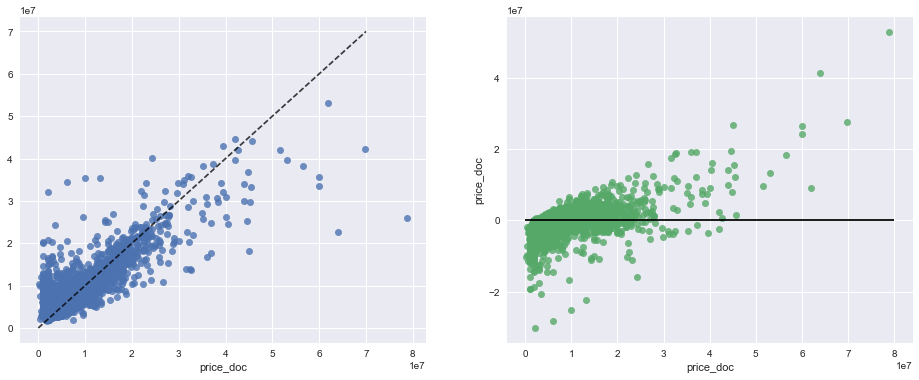

In [137]:
fig, ax = plt.subplots(1,2,figsize=[16,6])

sns.regplot(y_test, y_test_pred, fit_reg=False, ax=ax[0])
ax[0].plot(np.linspace(0, 7e7, 10), np.linspace(0, 7e7, 10), '--', color='black', alpha=0.75)

sns.regplot(y_test, y_test-y_test_pred, fit_reg=False, ax=ax[1])
sns.plt.hlines(y=0, xmin=0, xmax = 8e7)

In [7]:
import knnimpute as ki

In [14]:
x = X_train.drop('timestamp', axis=1).values
x = ki.knn_impute_few_observed(x, np.isnan(x), 15)

In [15]:
cols = X_train.drop('timestamp', axis=1).columns
x = pd.DataFrame(x)
x.columns = cols

In [20]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_pred = cross_val_predict(xgr, x, y_train, cv=5)
train_r2_score = r2_score(y_train, y_train_pred)

In [21]:
train_r2_score

0.68264406628446694

In [24]:
x = X_train.drop('timestamp', axis=1).values
x = ki.knn_impute_optimistic(x, np.isnan(x), 15)

In [25]:
cols = X_train.drop('timestamp', axis=1).columns
x = pd.DataFrame(x)
x.columns = cols

In [26]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_pred = cross_val_predict(xgr, x, y_train, cv=5)
train_r2_score = r2_score(y_train, y_train_pred)

print train_r2_score

0.679486954766


## Imputation

In [396]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_train_imp = X_train.drop(['timestamp'], axis=1)
train_cols = X_train_imp.columns
X_train_imp = pd.DataFrame(imp.fit_transform(X_train_imp))
X_train_imp.columns = train_cols

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_test_imp = X_test.drop(['timestamp'], axis=1)
test_cols = X_test_imp.columns
X_test_imp = pd.DataFrame(imp.fit_transform(X_test_imp))
X_test_imp.columns = test_cols

In [402]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_imp, y_test_imp, model_imp = model_eval(xgr, X_train_imp[train_cols], y_train, X_test_imp[train_cols], y_test)

train RMSLE:            0.472125330581
train CV R2_Score:      0.677202077058
train mse:              2750230.57833
test rmsle:             0.472660793459
test R2_Score:          0.686830739916
test mse:               2593884.48973


In [403]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_imp, y_test_macro_imp, model_macro_imp = model_eval(xgr, X_train_imp, y_train, X_test_imp, y_test)

train RMSLE:            0.471104193804
train CV R2_Score:      0.680994390348
train mse:              2734027.36129
test rmsle:             0.468594020169
test R2_Score:          0.699099346811
test mse:               2542568.33741


## Interpretation of timestamp

In [404]:
X_train_time = X_train.copy()
X_train_time['year'] = X_train_time['timestamp'].dt.year
X_train_time['month'] = X_train_time['timestamp'].dt.month
X_train_time['quarter'] = X_train_time['timestamp'].dt.quarter
X_train_time = X_train_time.drop(['timestamp'], axis=1)

X_test_time = X_test.copy()
X_test_time['year'] = X_test_time['timestamp'].dt.year
X_test_time['month'] = X_test_time['timestamp'].dt.month
X_test_time['quarter'] = X_test_time['timestamp'].dt.quarter
X_test_time = X_test_time.drop(['timestamp'], axis=1)

In [405]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_time, y_test_time, model_time = model_eval(xgr, X_train_time[train_cols], y_train, X_test_time[train_cols], y_test)

train RMSLE:            0.471889172903
train CV R2_Score:      0.681869572739
train mse:              2730277.33758
test rmsle:             0.469632796517
test R2_Score:          0.684553704598
test mse:               2603297.40152


In [406]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_time, y_test_time, model_macro_time = model_eval(xgr, X_train_time, y_train, X_test_time, y_test)

train RMSLE:            0.470371430212
train CV R2_Score:      0.679259855015
train mse:              2741449.67506
test rmsle:             0.46605135765
test R2_Score:          0.7015635191
test mse:               2532135.97981


## handling bugs from `build_year` field:

In [407]:
X_train_by = X_train_time.copy()
bad_index = (X_train_by.build_year == 0)
X_train_by.ix[bad_index, 'build_year'] = X_train_by.ix[bad_index].year
bad_index = (X_train_by.build_year == 1)
X_train_by.ix[bad_index, 'build_year'] = X_train_by.ix[bad_index].year-1
bad_index = (X_train_by.build_year == 3)
X_train_by.ix[bad_index, 'build_year'] = X_train_by.ix[bad_index].year-3
X_train_by.ix[X_train_by.build_year < 1600, 'build_year'] = np.nan
X_train_by.ix[X_train_by.build_year > 2018, 'build_year'] = np.nan

X_test_by = X_test_time.copy()
bad_index = (X_test_by.build_year == 0)
X_test_by.ix[bad_index, 'build_year'] = X_test_by.ix[bad_index].year
bad_index = (X_test_by.build_year == 1)
X_test_by.ix[bad_index, 'build_year'] = X_test_by.ix[bad_index].year-1
bad_index = (X_test_by.build_year == 3)
X_test_by.ix[bad_index, 'build_year'] = X_test_by.ix[bad_index].year-3
X_test_by.ix[X_test_by.build_year < 1600, 'build_year'] = np.nan
X_test_by.ix[X_test_by.build_year > 2018, 'build_year'] = np.nan

In [408]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_by, y_test_by, model_by = model_eval(xgr, X_train_by[train_cols], y_train, X_test_by[train_cols], y_test)

train RMSLE:            0.471302062961
train CV R2_Score:      0.682746638287
train mse:              2726507.15733
test rmsle:             0.468845236055
test R2_Score:          0.690467673637
test mse:               2578778.70388


In [409]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_by, y_test_macro_by, model_macro_by = model_eval(xgr, X_train_by, y_train, X_test_by, y_test)

train RMSLE:            0.469665428196
train CV R2_Score:      0.685900380094
train mse:              2712919.14779
test rmsle:             0.466233707307
test R2_Score:          0.703076070045
test mse:               2525711.07857


## treat wrong `build_year`s as NaN:

In [410]:
X_train_by_nan = X_train_time.copy()
bad_index = (X_train_by_nan.build_year == 0)
X_train_by_nan.ix[bad_index, 'build_year'] = np.nan
bad_index = (X_train_by_nan.build_year == 1)
X_train_by_nan.ix[bad_index, 'build_year'] = np.nan
bad_index = (X_train_by_nan.build_year == 3)
X_train_by_nan.ix[bad_index, 'build_year'] = np.nan
X_train_by_nan.ix[X_train_by_nan.build_year < 1600, 'build_year'] = np.nan
X_train_by_nan.ix[X_train_by_nan.build_year > 2018, 'build_year'] = np.nan

X_test_by_nan = X_test_time.copy()
bad_index = (X_test_by_nan.build_year == 0)
X_test_by_nan.ix[bad_index, 'build_year'] = np.nan
bad_index = (X_test_by_nan.build_year == 1)
X_test_by_nan.ix[bad_index, 'build_year'] = np.nan
bad_index = (X_test_by_nan.build_year == 3)
X_test_by_nan.ix[bad_index, 'build_year'] = np.nan
X_test_by_nan.ix[X_test_by_nan.build_year < 1600, 'build_year'] = np.nan
X_test_by_nan.ix[X_test_by_nan.build_year > 2018, 'build_year'] = np.nan

In [411]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_by_nan, y_test_by_nan, model_by_nan = model_eval(xgr, X_train_by_nan[train_cols], y_train, X_test_by_nan[train_cols], y_test)

train RMSLE:            0.471839593355
train CV R2_Score:      0.682359657831
train mse:              2728173.73138
test rmsle:             0.468688946365
test R2_Score:          0.693300377327
test mse:               2566951.65855


In [412]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_by_nan, y_test_macro_by_nan, model_macro_by_nan = model_eval(xgr, X_train_by_nan, y_train, X_test_by_nan, y_test)

train RMSLE:            0.469976410274
train CV R2_Score:      0.685284075129
train mse:              2715578.68991
test rmsle:             0.466823314199
test R2_Score:          0.694947541527
test mse:               2560049.32994


## handling outlier data in `full_sq, life_sq, kitch_sq`:

In [413]:
X_train_olsq = X_train_by_nan.copy()
X_train_olsq.ix[X_train_olsq.full_sq <= 6, 'full_sq'] = np.nan
X_train_olsq.ix[X_train_olsq.life_sq <= 6, 'life_sq'] = np.nan
X_train_olsq.ix[X_train_olsq.full_sq > 2000, 'full_sq'] = np.nan
X_train_olsq.ix[X_train_olsq.life_sq > 2000, 'life_sq'] = np.nan
bad_index = [11520, 13117, 21415, 28734]
X_train_olsq.ix[bad_index, 'kitch_sq'] = np.nan

X_test_olsq = X_test_by_nan.copy()
X_test_olsq.ix[X_test_olsq.full_sq <= 6, 'full_sq'] = np.nan
X_test_olsq.ix[X_test_olsq.life_sq <= 6, 'life_sq'] = np.nan
X_test_olsq.ix[X_test_olsq.full_sq > 2000, 'full_sq'] = np.nan
X_test_olsq.ix[X_test_olsq.life_sq > 2000, 'life_sq'] = np.nan
bad_index = [10368]
X_test_olsq.ix[bad_index, 'kitch_sq'] = np.nan

In [414]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_olsq, y_test_olsq, model_olsq = model_eval(xgr, X_train_olsq[train_cols], y_train, X_test_olsq[train_cols], y_test)

train RMSLE:            0.471469982594
train CV R2_Score:      0.677787500076
train mse:              2747743.1069
test rmsle:             0.468873968732
test R2_Score:          0.687973571324
test mse:               2589147.30378


In [415]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_olsq, y_test_macro_olsq, model_macro_olsq = model_eval(xgr, X_train_olsq, y_train, X_test_olsq, y_test)

train RMSLE:            0.470328248986
train CV R2_Score:      0.684964092425
train mse:              2716962.62599
test rmsle:             0.466143182247
test R2_Score:          0.699088450427
test mse:               2542614.37345


## try to correct the bad relations between `kitch-sq`, `life_sq`, `full_sq`

In [418]:
X_train_sq_cor = X_train_by_nan.copy()
bad_index = X_train_sq_cor.kitch_sq > X_train_sq_cor.life_sq
temp = X_train_sq_cor.ix[bad_index, 'kitch_sq']
X_train_sq_cor.ix[bad_index, 'kitch_sq'] = X_train_sq_cor.ix[bad_index, 'life_sq']
X_train_sq_cor.ix[bad_index, 'life_sq'] = temp

bad_index = X_train_sq_cor.kitch_sq > X_train_sq_cor.full_sq
temp = X_train_sq_cor.ix[bad_index, 'kitch_sq']
X_train_sq_cor.ix[bad_index, 'kitch_sq'] = X_train_sq_cor.ix[bad_index, 'full_sq']
X_train_sq_cor.ix[bad_index, 'full_sq'] = temp

bad_index = X_train_sq_cor.life_sq > X_train_sq_cor.full_sq
temp = X_train_sq_cor.ix[bad_index, 'life_sq']
X_train_sq_cor.ix[bad_index, 'life_sq'] = X_train_sq_cor.ix[bad_index, 'full_sq']
X_train_sq_cor.ix[bad_index, 'full_sq'] = temp


X_test_sq_cor = X_test_by_nan.copy()
bad_index = X_test_sq_cor.kitch_sq > X_test_sq_cor.life_sq
temp = X_test_sq_cor.ix[bad_index, 'kitch_sq']
X_test_sq_cor.ix[bad_index, 'kitch_sq'] = X_test_sq_cor.ix[bad_index, 'life_sq']
X_test_sq_cor.ix[bad_index, 'life_sq'] = temp

bad_index = X_test_sq_cor.kitch_sq > X_test_sq_cor.full_sq
temp = X_test_sq_cor.ix[bad_index, 'kitch_sq']
X_test_sq_cor.ix[bad_index, 'kitch_sq'] = X_test_sq_cor.ix[bad_index, 'full_sq']
X_test_sq_cor.ix[bad_index, 'full_sq'] = temp

bad_index = X_test_sq_cor.life_sq > X_test_sq_cor.full_sq
temp = X_test_sq_cor.ix[bad_index, 'life_sq']
X_test_sq_cor.ix[bad_index, 'life_sq'] = X_test_sq_cor.ix[bad_index, 'full_sq']
X_test_sq_cor.ix[bad_index, 'full_sq'] = temp

In [419]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_sq_cor, y_test_sq_cor, model_sq_cor = model_eval(xgr, X_train_sq_cor[train_cols], y_train, X_test_sq_cor[train_cols], y_test)

train RMSLE:            0.471475102698
train CV R2_Score:      0.674277035916
train mse:              2762660.33947
test rmsle:             0.46877001211
test R2_Score:          0.700619451054
test mse:               2536137.87181


In [420]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_sq_cor, y_test_macro_sq_cor, model_macro_sq_cor = model_eval(xgr, X_train_sq_cor, y_train, X_test_sq_cor, y_test)

train RMSLE:            0.470264610438
train CV R2_Score:      0.679773504738
train mse:              2739251.48662
test rmsle:             0.465257647144
test R2_Score:          0.711000354993
test mse:               2491780.16138


## treat the bad values of `kitch-sq`, `life_sq`, `full_sq` as NaN

In [421]:
X_train_sq_nan = X_train_by_nan.copy()
bad_index = X_train_sq_nan.kitch_sq > X_train_sq_nan.life_sq
X_train_sq_nan.ix[bad_index, 'kitch_sq'] = np.nan
bad_index = X_train_sq_nan.kitch_sq > X_train_sq_nan.full_sq
X_train_sq_nan.ix[bad_index, 'kitch_sq'] = np.nan
bad_index = X_train_sq_nan.life_sq > X_train_sq_nan.full_sq
X_train_sq_nan.ix[bad_index, 'life_sq'] = np.nan

X_test_sq_nan = X_test_by_nan.copy()
bad_index = X_test_sq_nan.kitch_sq > X_test_sq_nan.life_sq
X_test_sq_nan.ix[bad_index, 'kitch_sq'] = np.nan
bad_index = X_test_sq_nan.kitch_sq > X_test_sq_nan.full_sq
X_test_sq_nan.ix[bad_index, 'kitch_sq'] = np.nan
bad_index = X_test_sq_nan.life_sq > X_test_sq_nan.full_sq
X_test_sq_nan.ix[bad_index, 'life_sq'] = np.nan

In [422]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_sq_nan, y_test_sq_nan, model_sq_nan = model_eval(xgr, X_train_sq_nan[train_cols], y_train, X_test_sq_nan[train_cols], y_test)

train RMSLE:            0.471501571481
train CV R2_Score:      0.683167505539
train mse:              2724701.60208
test rmsle:             0.469159404948
test R2_Score:          0.692285354709
test mse:               2571195.81411


In [423]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_sq_nan, y_test_macro_sq_nan, model_macro_sq_nan = model_eval(xgr, X_train_sq_nan, y_train, X_test_sq_nan, y_test)

train RMSLE:            0.470419295596
train CV R2_Score:      0.685249175137
train mse:              2715734.10422
test rmsle:             0.465798337217
test R2_Score:          0.698998593767
test mse:               2542993.97633


## treat outliers in `num_room` as NaN

In [424]:
X_train_room = X_train_by_nan.copy()
bad_index = X_train_room.ix[(X_train_room.num_room>=6) & (X_train_room.full_sq<100)].index
X_train_room.ix[bad_index, 'num_room'] = np.nan

X_test_room = X_test_by_nan.copy()
bad_index = X_test_room.ix[(X_test_room.num_room>=6) & (X_test_room.full_sq<100)].index
X_test_room.ix[bad_index, 'num_room'] = np.nan

In [425]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_room, y_test_room, model_room = model_eval(xgr, X_train_room[train_cols], y_train, X_test_room[train_cols], y_test)

train RMSLE:            0.471653750005
train CV R2_Score:      0.682806943763
train mse:              2726250.72267
test rmsle:             0.468247437838
test R2_Score:          0.692974705482
test mse:               2568314.16769


In [426]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_room, y_test_macro_room, model_macro_room = model_eval(xgr, X_train_room, y_train, X_test_room, y_test)

train RMSLE:            0.469813872092
train CV R2_Score:      0.687314919626
train mse:              2706804.59335
test rmsle:             0.465831191293
test R2_Score:          0.702523331543
test mse:               2528060.85323


## Replacing `floor` with `max_floor` for wrong values

In [427]:
X_train_floor = X_train_room.copy()
bad_index = X_train_floor.floor > X_train_floor.max_floor
temp = X_train_floor.ix[bad_index, 'floor']
X_train_floor.ix[bad_index, 'floor'] = X_train_floor.ix[bad_index, 'max_floor']
X_train_floor.ix[bad_index, 'max_floor'] = temp

X_test_floor = X_test_room.copy()
bad_index = X_test_floor.floor > X_test_floor.max_floor
temp = X_test_floor.ix[bad_index, 'floor']
X_test_floor.ix[bad_index, 'floor'] = X_test_floor.ix[bad_index, 'max_floor']
X_test_floor.ix[bad_index, 'max_floor'] = temp

In [428]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_floor, y_test_floor, mode_floor = model_eval(xgr, X_train_floor[train_cols], y_train, X_test_floor[train_cols], y_test)

train RMSLE:            0.471750147515
train CV R2_Score:      0.679582990943
train mse:              2740069.01804
test rmsle:             0.468794735434
test R2_Score:          0.688778890812
test mse:               2585803.93652


In [429]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_floor, y_test_macro_floor, model_macro_floor = model_eval(xgr, X_train_floor, y_train, X_test_floor, y_test)

train RMSLE:            0.469498989628
train CV R2_Score:      0.685683764192
train mse:              2713860.0449
test rmsle:             0.466811367815
test R2_Score:          0.69964862586
test mse:               2540246.61189


## treat wring values in `floor` as NaN

In [430]:
X_train_floor_nan = X_train_room.copy()
bad_index = X_train_floor_nan.floor > X_train_floor_nan.max_floor
X_train_floor_nan.ix[bad_index, 'floor'] = np.nan

X_test_floor_nan = X_test_room.copy()
bad_index = X_test_floor_nan.floor > X_test_floor_nan.max_floor
X_test_floor_nan.ix[bad_index, 'floor'] = np.nan

In [431]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_floor_nan, y_test_floor_nan, model_floor_nan = model_eval(xgr, X_train_floor_nan[train_cols], y_train, X_test_floor_nan[train_cols], y_test)

train RMSLE:            0.471160603045
train CV R2_Score:      0.68446714468
train mse:              2719099.10427
test rmsle:             0.47019142996
test R2_Score:          0.687546536036
test mse:               2590918.43456


In [432]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_floor_nan, y_test_macro_floor_nan, model_macro_floor_nan = model_eval(xgr, X_train_floor_nan, y_train, X_test_floor_nan, y_test)

train RMSLE:            0.470101157574
train CV R2_Score:      0.686663676266
train mse:              2709620.19403
test rmsle:             0.466778328079
test R2_Score:          0.70244241287
test mse:               2528404.66745


## remove outlier from `state`

In [433]:
X_train_state = X_train_floor_nan.copy()
X_train_state.ix[X_train_state.state > 30, 'state'] = np.nan

X_test_state = X_test_floor_nan.copy()
X_test_state.ix[X_test_state.state > 30, 'state'] = np.nan

In [434]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_state, y_test_state, model_state = model_eval(xgr, X_train_state[train_cols], y_train, X_test_state[train_cols], y_test)

train RMSLE:            0.471356346238
train CV R2_Score:      0.682132988996
train mse:              2729147.79091
test rmsle:             0.469443501768
test R2_Score:          0.69020472146
test mse:               2579873.8262


In [435]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_state, y_test_macro_state, model_macro_state = model_eval(xgr, X_train_state, y_train, X_test_state, y_test)

train RMSLE:            0.470066637429
train CV R2_Score:      0.686721547451
train mse:              2709371.54627
test rmsle:             0.465975297501
test R2_Score:          0.70225947509
test mse:               2529181.77697


## Adding age instead of build_year

In [438]:
X_train_age = X_train_floor_nan
X_train_age['age'] = X_train_age.year - X_train_age['build_year']
#X_train_age = X_train_age.drop('build_year', axis=1)

X_test_age = X_test_floor_nan
X_test_age['age'] = X_test_age.year - X_test_age['build_year']
#X_test_age = X_test_age.drop('build_year', axis=1)

In [439]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_age, y_test_age, model_age = model_eval(xgr, 
                                                X_train_age[train_cols].drop('build_year', axis=1),y_train, 
                                                X_test_age[train_cols].drop('build_year', axis=1), y_test)

train RMSLE:            0.472554629412
train CV R2_Score:      0.677587723146
train mse:              2748587.20182
test rmsle:             0.469171383231
test R2_Score:          0.6871434238
test mse:               2592589.2342


In [440]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=200, 
                   early_stopping_rounds=50)

y_train_macro_age, y_test_macro_age, model_macro_age = model_eval(xgr, 
                                                                  X_train_age.drop('build_year', axis=1), y_train,
                                                                  X_test_age.drop('build_year', axis=1), y_test)

train RMSLE:            0.470739608554
train CV R2_Score:      0.681978094944
train mse:              2729809.13468
test rmsle:             0.467001148968
test R2_Score:          0.694770396992
test mse:               2560792.53478


## Some feature engineering

In [441]:
X_train_sq_ratio = X_train_floor_nan.copy()
X_train_sq_ratio['life_ratio'] = X_train_sq_ratio['life_sq']/X_train_sq_ratio['full_sq']
X_train_sq_ratio['kitch_ratio'] = X_train_sq_ratio['kitch_sq']/X_train_sq_ratio['life_sq']
X_train_sq_ratio['room_sq'] = X_train_sq_ratio['life_sq']/X_train_sq_ratio['num_room']

X_test_sq_ratio = X_test_floor_nan.copy()
X_test_sq_ratio['life_ratio'] = X_test_sq_ratio['life_sq']/X_test_sq_ratio['full_sq']
X_test_sq_ratio['kitch_ratio'] = X_test_sq_ratio['kitch_sq']/X_test_sq_ratio['life_sq']
X_test_sq_ratio['room_sq'] = X_test_sq_ratio['life_sq']/X_test_sq_ratio['num_room']

In [442]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_sq_ratio, y_test_sq_ratio, model_sq_ratio = model_eval(xgr, X_train_sq_ratio[train_cols], y_train, X_test_sq_ratio[train_cols], y_test)

train RMSLE:            0.473220000335
train CV R2_Score:      0.681748085584
train mse:              2730801.13802
test rmsle:             0.472017302177
test R2_Score:          0.682826229664
test mse:               2610415.87299


In [443]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_macro_sq_ratio, y_test_macro_sq_ratio, model_macro_sq_ratio = model_eval(xgr, X_train_sq_ratio, y_train, X_test_sq_ratio, y_test)

train RMSLE:            0.471652186127
train CV R2_Score:      0.677742695625
train mse:              2747924.36736
test rmsle:             0.468629357369
test R2_Score:          0.701290764585
test mse:               2533292.832


## All bug removal from dataset and feature engineering

In [444]:
X_train_eng_all = X_train.copy()

X_train_eng_all.ix[X_train_eng_all.full_sq <= 6, 'full_sq'] = np.nan
X_train_eng_all.ix[X_train_eng_all.life_sq <= 6, 'life_sq'] = np.nan

X_train_eng_all.ix[X_train_eng_all.full_sq > 2000, 'full_sq'] = np.nan
X_train_eng_all.ix[X_train_eng_all.life_sq > 2000, 'life_sq'] = np.nan

bad_index = [11520, 13117, 21415, 28734]
X_train_eng_all.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = X_train_eng_all.ix[(X_train_eng_all.num_room>=6) & (X_train_eng_all.full_sq<100)].index
X_train_eng_all.ix[bad_index, 'num_room'] = np.nan

bad_index = X_train_eng_all.kitch_sq > X_train_eng_all.life_sq
X_train_eng_all.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = X_train_eng_all.kitch_sq > X_train_eng_all.full_sq
X_train_eng_all.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = X_train_eng_all.life_sq > X_train_eng_all.full_sq
X_train_eng_all.ix[bad_index, 'life_sq'] = np.nan

bad_index = X_train_eng_all.floor > X_train_eng_all.max_floor
X_train_eng_all.ix[bad_index, 'floor'] = np.nan

X_train_eng_all.ix[X_train_eng_all.state > 30, 'state'] = np.nan

X_train_eng_all.timestamp = pd.to_datetime(X_train_eng_all.timestamp)
bad_index = (X_train_eng_all.build_year <= 0)
X_train_eng_all.ix[bad_index, 'build_year'] = np.nan
X_train_eng_all.ix[X_train_eng_all.build_year < 1600, 'build_year'] = np.nan
X_train_eng_all.ix[X_train_eng_all.build_year > 2018, 'build_year'] = np.nan

X_train_eng_all = X_train_eng_all.drop('timestamp', axis=1)



X_test_eng_all = X_test.copy()

X_test_eng_all.ix[X_test_eng_all.full_sq <= 6, 'full_sq'] = np.nan
X_test_eng_all.ix[X_test_eng_all.life_sq <= 6, 'life_sq'] = np.nan

X_test_eng_all.ix[X_test_eng_all.full_sq > 2000, 'full_sq'] = np.nan
X_test_eng_all.ix[X_test_eng_all.life_sq > 2000, 'life_sq'] = np.nan

bad_index = [10368]
X_test_eng_all.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = X_test_eng_all.ix[(X_test_eng_all.num_room>=6) & (X_test_eng_all.full_sq<100)].index
X_test_eng_all.ix[bad_index, 'num_room'] = np.nan

bad_index = X_test_eng_all.kitch_sq > X_test_eng_all.life_sq
X_test_eng_all.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = X_test_eng_all.kitch_sq > X_test_eng_all.full_sq
X_test_eng_all.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = X_test_eng_all.life_sq > X_test_eng_all.full_sq
X_test_eng_all.ix[bad_index, 'life_sq'] = np.nan

bad_index = X_test_eng_all.floor > X_test_eng_all.max_floor
X_test_eng_all.ix[bad_index, 'floor'] = np.nan

X_test_eng_all.ix[X_test_eng_all.state > 30, 'state'] = np.nan

X_test_eng_all.timestamp = pd.to_datetime(X_test_eng_all.timestamp)
bad_index = (X_test_eng_all.build_year <= 0)
X_test_eng_all.ix[bad_index, 'build_year'] = np.nan
X_test_eng_all.ix[X_test_eng_all.build_year < 1600, 'build_year'] = np.nan
X_test_eng_all.ix[X_test_eng_all.build_year > 2018, 'build_year'] = np.nan

X_test_eng_all = X_test_eng_all.drop('timestamp', axis=1)

In [445]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_eng_all, y_test_eng_all, model_eng_all = model_eval(xgr, X_train_eng_all[train_cols], y_train, X_test_eng_all[train_cols], y_test)

train RMSLE:            0.474416968508
train CV R2_Score:      0.674801120567
train mse:              2760436.78232
test rmsle:             0.471518402576
test R2_Score:          0.685335877558
test mse:               2600067.86185


In [446]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_macro_eng_all, y_test_macro_eng_all, model_macro_eng_all = model_eval(xgr, X_train_eng_all, y_train, X_test_eng_all, y_test)

train RMSLE:            0.470656586558
train CV R2_Score:      0.685335342986
train mse:              2715361.09495
test rmsle:             0.468537370241
test R2_Score:          0.699719732343
test mse:               2539945.89961


## Imputation + Feature Engineering

In [447]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
train_cols = X_train_eng_all.columns
X_train_eng_imp = pd.DataFrame(imp.fit_transform(X_train_eng_all))
X_train_eng_imp.columns = train_cols

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
test_cols = X_test_eng_all.columns
X_test_eng_imp = pd.DataFrame(imp.fit_transform(X_test_eng_all))
X_test_eng_imp.columns = test_cols

In [448]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_eng_imp, y_test_eng_imp, model_eng_imp = model_eval(xgr, X_train_eng_imp[train_cols], y_train, X_test_eng_imp[train_cols], y_test)

train RMSLE:            0.471940910082
train CV R2_Score:      0.681918720615
train mse:              2730063.8908
test rmsle:             0.468659594957
test R2_Score:          0.705131501361
test mse:               2516953.88412


In [449]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_macro_macro_eng_imp, y_test_macro_macro_eng_imp, model_macro_eng_imp = model_eval(xgr, X_train_eng_imp, y_train, X_test_eng_imp, y_test)

train RMSLE:            0.471940910082
train CV R2_Score:      0.681918720615
train mse:              2730063.8908
test rmsle:             0.468659594957
test R2_Score:          0.705131501361
test mse:               2516953.88412


## Feature importance

In [459]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train[train_cols], y_train)

model_xgb = xgb.train(dict(xgb_params,silent=0),dtrain,num_boost_round=100)

<function matplotlib.pyplot.show>

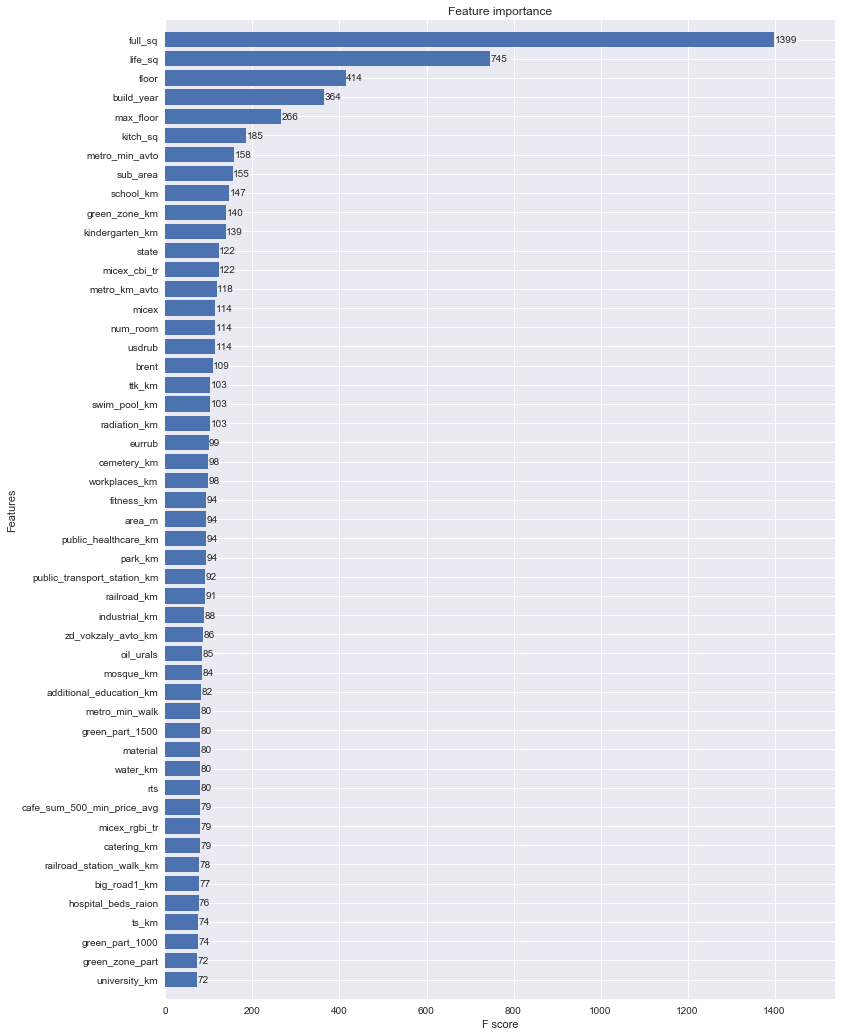

In [453]:
fig,ax=plt.subplots(figsize = (12,18))
xgb.plot_importance(model_xgb, max_num_features=50, height=0.8, ax=ax)
plt.show

In [454]:
imporatan_cols = model_xgb.feature_names[:100]
X_train_feat_imp = X_train[imporatan_cols]
X_test_feat_imp = X_test[imporatan_cols]

In [455]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_feat_imp, y_test_feat_imp, model_feat_eng = model_eval(xgr, X_train_feat_imp, y_train, X_test_feat_imp, y_test)

train RMSLE:            0.471995577659
train CV R2_Score:      0.680524626757
train mse:              2736038.60932
test rmsle:             0.468594099689
test R2_Score:          0.67806740436
test mse:               2629926.09771


## Using feature importance on train_macro

In [456]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train.drop('timestamp', axis=1), y_train)

model_xgb = xgb.train(dict(xgb_params,silent=0),dtrain,num_boost_round=100)

<function matplotlib.pyplot.show>

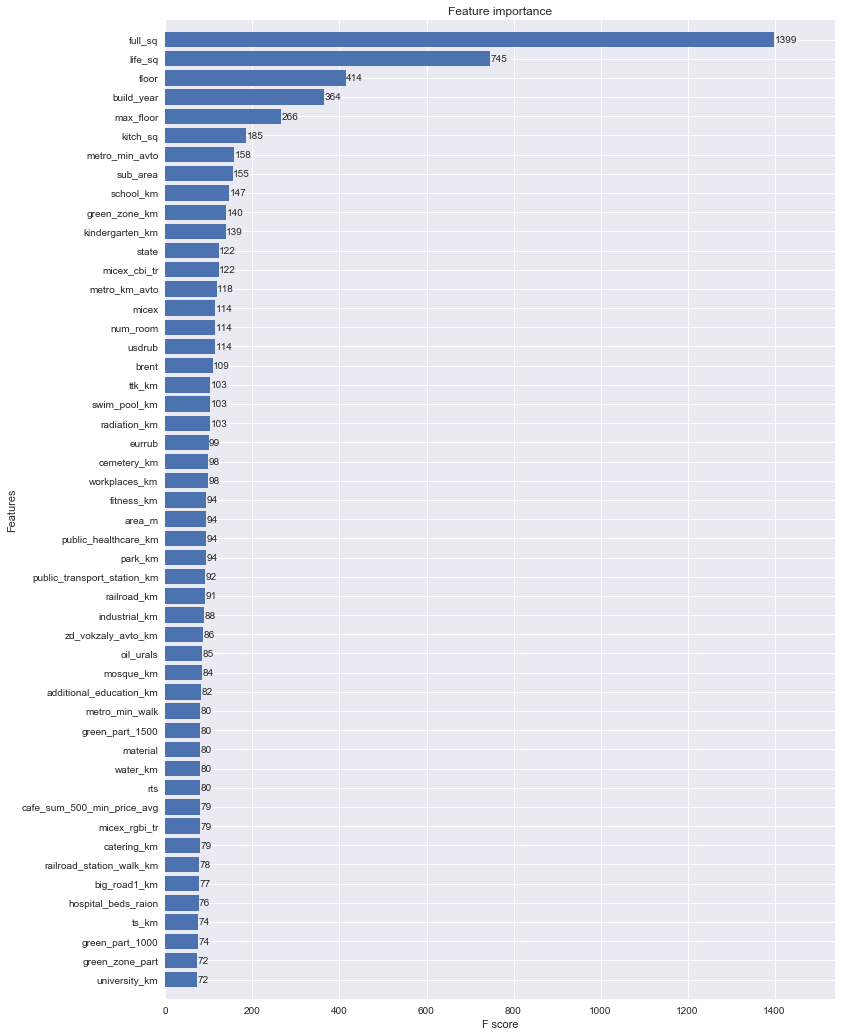

In [366]:
fig,ax=plt.subplots(figsize = (12,18))
xgb.plot_importance(model_xgb, max_num_features=50, height=0.8, ax=ax)
plt.show

In [462]:
imporatan_cols = model_xgb.feature_names[:300]
X_train_macro_feat_imp = X_train[imporatan_cols]
X_test_macro_feat_imp = X_test[imporatan_cols]

In [463]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_macro_feat_imp, y_test_macro_feat_imp, model_macro_feat_imp = model_eval(xgr, X_train_macro_feat_imp, y_train, X_test_macro_feat_imp, y_test)

train RMSLE:            0.471123298111
train CV R2_Score:      0.681362129797
train mse:              2732452.04567
test rmsle:             0.467915196598
test R2_Score:          0.70478050264
test mse:               2518451.47516


## Dimension Reduction

In [287]:
n_comp = 150

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
X_train_svd = tsvd.fit_transform(X_train_eng_imp)
X_test_svd = tsvd.transform(X_test_eng_imp)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
X_train_pca = pca.fit_transform(X_train_eng_imp)
X_test_pca = pca.transform(X_test_eng_imp)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
X_train_ica = ica.fit_transform(X_train_eng_imp)
X_test_ica = ica.transform(X_test_eng_imp)

In [275]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_ica, y_test_ica = model_eval(xgr, X_train_ica, y_train, X_test_ica, y_test)

train CV R2_Score:      0.619290649059
train mse:              2986761.20475
test R2_Score:          0.65103434539
test mse:               2738119.58693


In [279]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_pca, y_test_pca = model_eval(xgr, X_train_pca, y_train, X_test_pca, y_test)

train CV R2_Score:      0.646555606527
train mse:              2877820.96837
test R2_Score:          0.653132551254
test mse:               2729875.50843


In [280]:
xgr = XGBRegressor(max_depth=6, 
                   learning_rate=0.1, 
                   subsample=0.8, 
                   colsample_bytree=0.8, 
                   n_estimators=350, 
                   early_stopping_rounds=50)

y_train_svd, y_test_svd = model_eval(xgr, X_train_svd, y_train, X_test_svd, y_test)

train CV R2_Score:      0.645979178442
train mse:              2880164.79102
test R2_Score:          0.660793844359
test mse:               2699559.67141
